In [1]:
from modules.hand_visualizations import *
DATASET_PATH = "/Users/christina/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2"

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

Classifiers

In [3]:

class RPSTraditionalMLClassifier:
    """Traditional ML classification using different hand representations"""
    
    def __init__(self):
        self.processor = HandVisualRepresentations()
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.models = {}
        
    def extract_features_from_representation(self, representation, rep_type):
        """Extract features from different representations for traditional ML"""
        
        if rep_type == 'raw_rgb':
            # Use PCA to reduce dimensionality of raw RGB
            features = representation.flatten()
            return features
            
        elif rep_type == 'seg_mask':
            # Extract geometric features from segmentation mask
            features = []
            
            # Basic shape features
            total_pixels = np.sum(representation > 0.5)
            features.append(total_pixels)
            
            # Bounding box features
            coords = np.where(representation > 0.5)
            if len(coords[0]) > 0:
                min_y, max_y = np.min(coords[0]), np.max(coords[0])
                min_x, max_x = np.min(coords[1]), np.max(coords[1])
                height = max_y - min_y
                width = max_x - min_x
                aspect_ratio = width / height if height > 0 else 0
                
                features.extend([height, width, aspect_ratio])
                
                # Centroid
                centroid_y = np.mean(coords[0])
                centroid_x = np.mean(coords[1])
                features.extend([centroid_y, centroid_x])
            else:
                features.extend([0, 0, 0, 0, 0])
            
            # Moments and shape descriptors
            import cv2
            mask_uint8 = (representation * 255).astype(np.uint8)
            moments = cv2.moments(mask_uint8)
            
            # Hu moments (7 invariant moments)
            hu_moments = cv2.HuMoments(moments)
            features.extend(hu_moments.flatten())
            
            # Solidity, extent, eccentricity
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                area = cv2.contourArea(largest_contour)
                hull = cv2.convexHull(largest_contour)
                hull_area = cv2.contourArea(hull)
                solidity = area / hull_area if hull_area > 0 else 0
                
                # Bounding rectangle
                x, y, w, h = cv2.boundingRect(largest_contour)
                extent = area / (w * h) if w * h > 0 else 0
                
                features.extend([solidity, extent])
            else:
                features.extend([0, 0])
                
            return np.array(features)
            
        elif rep_type == 'edges':
            # Extract edge-based features
            features = []
            
            # Edge density
            edge_density = np.sum(representation > 0.5) / representation.size
            features.append(edge_density)
            
            # Edge distribution (divide image into grid and count edges in each cell)
            h, w = representation.shape
            grid_size = 4
            for i in range(grid_size):
                for j in range(grid_size):
                    y_start = i * h // grid_size
                    y_end = (i + 1) * h // grid_size
                    x_start = j * w // grid_size
                    x_end = (j + 1) * w // grid_size
                    
                    cell_edges = np.sum(representation[y_start:y_end, x_start:x_end] > 0.5)
                    features.append(cell_edges)
            
            # Hough lines features
            import cv2
            edges_uint8 = (representation * 255).astype(np.uint8)
            lines = cv2.HoughLines(edges_uint8, 1, np.pi/180, threshold=50)
            num_lines = len(lines) if lines is not None else 0
            features.append(num_lines)
            
            return np.array(features)
            
        elif rep_type == 'landmarks':
            # Landmarks are already feature vectors
            features = []
            
            # Flatten landmarks
            landmarks_flat = representation.flatten()
            features.extend(landmarks_flat)
            
            # Calculate additional geometric features from landmarks
            if np.any(landmarks_flat):
                landmarks_2d = representation.reshape(-1, 2)
                valid_landmarks = landmarks_2d[np.any(landmarks_2d, axis=1)] # filter out invalid landmarks
                
                if len(valid_landmarks) > 1:
                    # Hand span
                    x_span = np.max(valid_landmarks[:, 0]) - np.min(valid_landmarks[:, 0])
                    y_span = np.max(valid_landmarks[:, 1]) - np.min(valid_landmarks[:, 1])
                    
                    # Centroid
                    centroid = np.mean(valid_landmarks, axis=0)
                    
                    # Distances from centroid
                    distances = np.linalg.norm(valid_landmarks - centroid, axis=1)
                    mean_distance = np.mean(distances)
                    std_distance = np.std(distances)
                    
                    features.extend([x_span, y_span, centroid[0], centroid[1], 
                                   mean_distance, std_distance])
                else:
                    features.extend([0, 0, 0, 0, 0, 0])
            else:
                features.extend([0, 0, 0, 0, 0, 0])
                
            return np.array(features)
    
    def prepare_traditional_ml_dataset(self, image_paths, labels, representation_types):
        """Prepare dataset for traditional ML with multiple representations"""
        
        X_combined = []
        y = []
        
        print(f"Processing {len(image_paths)} images...")
        
        for i, (img_path, label) in enumerate(zip(image_paths, labels)):
            try:
                representations, _ = self.processor.process_rps_image(img_path)
                
                # Extract features from each representation type
                combined_features = []
                for rep_type in representation_types:
                    if rep_type in representations:
                        features = self.extract_features_from_representation(
                            representations[rep_type], rep_type
                        )
                        combined_features.extend(features)
                
                if combined_features:
                    X_combined.append(combined_features)
                    y.append(label)
                    
                if (i + 1) % 50 == 0:
                    print(f"Processed {i + 1}/{len(image_paths)} images")
                    
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        X = np.array(X_combined)
        y = np.array(y)
        
        print(f"Final dataset shape: {X.shape}")
        print(f"Labels distribution: {np.unique(y, return_counts=True)}")
        
        return X, y
    
    def train_traditional_models(self, X, y):
        """Train multiple traditional ML models"""
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Apply PCA if feature dimension is too high
        if X_train_scaled.shape[1] > 1000:
            print("Applying PCA for dimensionality reduction...")
            self.pca = PCA(n_components=min(500, X_train_scaled.shape[0] - 1))
            X_train_scaled = self.pca.fit_transform(X_train_scaled)
            X_test_scaled = self.pca.transform(X_test_scaled)
            print(f"Reduced dimensions to: {X_train_scaled.shape[1]}")
        
        # Define models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'K-NN': KNeighborsClassifier(n_neighbors=5),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        
        # Train and evaluate models
        results = {}
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_scaled)
            
            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
            
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'predictions': y_pred,
                'true_labels': y_test
            }
            
            print(f"Accuracy: {accuracy:.4f}")
            print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            
            # Classification report
            class_names = self.label_encoder.classes_
            print(f"\nClassification Report for {name}:")
            print(classification_report(y_test, y_pred, target_names=class_names))
        
        self.models = results
        return results, X_test_scaled, y_test
    
    def visualize_results(self, results):
        """Visualize traditional ML results"""
        
        # Model comparison
        model_names = list(results.keys())
        accuracies = [results[name]['accuracy'] for name in model_names]
        cv_means = [results[name]['cv_mean'] for name in model_names]
        cv_stds = [results[name]['cv_std'] for name in model_names]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Accuracy comparison
        ax1.bar(model_names, accuracies, alpha=0.7)
        ax1.set_title('Model Accuracy Comparison')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim([0, 1])
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        # CV scores with error bars
        ax2.errorbar(model_names, cv_means, yerr=cv_stds, fmt='o', capsize=5)
        ax2.set_title('Cross-Validation Scores')
        ax2.set_ylabel('CV Score')
        ax2.set_ylim([0, 1])
        plt.setp(ax2.get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Confusion matrices for best model
        best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
        best_result = results[best_model_name]
        
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(best_result['true_labels'], best_result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title(f'Confusion Matrix - {best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


class RPSCNNClassifier(nn.Module):
    """Convolutional Neural Network for RPS classification"""
    
    def __init__(self, num_classes=3, input_channels=3):
        super(RPSCNNClassifier, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        # Assuming input size is 224x224, after 4 pooling operations: 224/16 = 14
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Conv block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Conv block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Conv block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


class RPSLandmarkMLP(nn.Module):
    """MLP for landmark-based classification"""
    
    def __init__(self, input_size=42, num_classes=3):  # 21 landmarks * 2 coordinates
        super(RPSLandmarkMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


class RPSDeepLearningClassifier:
    """Deep Learning classifier with multiple architectures"""
    
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.label_encoder = LabelEncoder()
        
    def create_data_loaders(self, image_paths, labels, representation_type='raw_rgb', 
                           batch_size=32, val_split=0.2):
        """Create PyTorch data loaders"""
        
        # Encode labels
        labels_encoded = self.label_encoder.fit_transform(labels)
        
        # Split data
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            image_paths, labels_encoded, test_size=val_split, random_state=42, 
            stratify=labels_encoded
        )
        
        # Define transforms
        if representation_type in ['raw_rgb', 'seg_mask', 'edges']:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])
            ])
        else:
            transform = None
        
        # Create datasets
        train_dataset = RPSRepresentationDataset(
            train_paths, train_labels, representation_type, transform
        )
        val_dataset = RPSRepresentationDataset(
            val_paths, val_labels, representation_type, transform
        )
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        return train_loader, val_loader
    
    def train_cnn_model(self, train_loader, val_loader, num_epochs=50, lr=0.001):
        """Train CNN model"""
        
        # Determine input channels
        sample_batch = next(iter(train_loader))
        input_channels = sample_batch[0].shape[1]
        
        # Initialize model
        model = RPSCNNClassifier(num_classes=3, input_channels=input_channels).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        
        # Training history
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"Training CNN model on {self.device}...")
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            # Calculate metrics
            train_acc = 100 * train_correct / train_total
            val_acc = 100 * val_correct / val_total
            
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            scheduler.step()
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Train Loss: {train_loss/len(train_loader):.4f}, '
                      f'Train Acc: {train_acc:.2f}%, '
                      f'Val Loss: {val_loss/len(val_loader):.4f}, '
                      f'Val Acc: {val_acc:.2f}%')
        
        return model, {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    
    def train_landmark_mlp(self, train_loader, val_loader, num_epochs=100, lr=0.001):
        """Train MLP for landmark classification"""
        
        # Initialize model
        model = RPSLandmarkMLP(input_size=42, num_classes=3).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        
        # Training history
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"Training Landmark MLP on {self.device}...")
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            # Calculate metrics
            train_acc = 100 * train_correct / train_total
            val_acc = 100 * val_correct / val_total
            
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            scheduler.step()
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Train Loss: {train_loss/len(train_loader):.4f}, '
                      f'Train Acc: {train_acc:.2f}%, '
                      f'Val Loss: {val_loss/len(val_loader):.4f}, '
                      f'Val Acc: {val_acc:.2f}%')
        
        return model, {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    
    def plot_training_history(self, history, title="Training History"):
        """Plot training and validation curves"""
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Loss curves
        ax1.plot(history['train_losses'], label='Training Loss')
        ax1.plot(history['val_losses'], label='Validation Loss')
        ax1.set_title(f'{title} - Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy curves
        ax2.plot(history['train_accuracies'], label='Training Accuracy')
        ax2.plot(history['val_accuracies'], label='Validation Accuracy')
        ax2.set_title(f'{title} - Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


In [4]:
# Example usage and comparison
def run_comprehensive_rps_classification_experiment(dataset_path):
    """Run comprehensive experiment comparing all approaches"""
    
    print("=== Rock-Paper-Scissors Classification Experiment ===\n")
    
    # 1. Load and explore dataset
    print("1. Loading dataset...")
    image_paths, labels, class_images = explore_rps_dataset(dataset_path)
    
    if not image_paths:
        print("No valid dataset found!")
        return
    
    # 2. Traditional ML Classification
    print("\n2. Traditional ML Classification")
    ml_classifier = RPSTraditionalMLClassifier()
    
    # Test different representation combinations
    representation_combinations = [
        ['landmarks'],
        ['seg_mask'],
        ['edges'],
        ['landmarks', 'seg_mask'],
        ['landmarks', 'edges'],
        ['seg_mask', 'edges'],
        ['landmarks', 'seg_mask', 'edges']
    ]
    
    best_ml_result = None
    best_ml_accuracy = 0
    
    for rep_combo in representation_combinations:
        print(f"\nTesting combination: {rep_combo}")
        
        try:
            X, y = ml_classifier.prepare_traditional_ml_dataset(
                image_paths, labels, rep_combo  # Use subset for demo
                #image_paths[:200], labels[:200], rep_combo  # Use subset for demo
            )
            
            if len(X) < 10:  # Need minimum samples
                continue
                
            results, X_test, y_test = ml_classifier.train_traditional_models(X, y)
            
            # Find best model
            best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
            best_accuracy = results[best_model_name]['accuracy']
            
            if best_accuracy > best_ml_accuracy:
                best_ml_accuracy = best_accuracy
                best_ml_result = (rep_combo, results)
                
        except Exception as e:
            print(f"Error with combination {rep_combo}: {e}")
            continue
    
    if best_ml_result:
        print(f"\nBest Traditional ML Result:")
        print(f"Representations: {best_ml_result[0]}")
        print(f"Best Accuracy: {best_ml_accuracy:.4f}")
        ml_classifier.visualize_results(best_ml_result[1])
    
    # 3. Deep Learning Classification
    print("\n3. Deep Learning Classification")
    dl_classifier = RPSDeepLearningClassifier()
    
    # CNN with different representations
    cnn_results = {}
    
    for rep_type in ['raw_rgb', 'seg_mask', 'edges']:
        print(f"\nTraining CNN with {rep_type} representation...")
        
        try:
            train_loader, val_loader = dl_classifier.create_data_loaders(
                image_paths, labels, rep_type, batch_size=32  # Subset for demo
                #image_paths[:200], labels[:200], rep_type, batch_size=16  # Subset for demo
            )
            
            model, history = dl_classifier.train_cnn_model(
                train_loader, val_loader, num_epochs=20  # Reduced for demo
            )
            
            cnn_results[rep_type] = {
                'model': model,
                'history': history,
                'best_val_acc': max(history['val_accuracies'])
            }
            
            dl_classifier.plot_training_history(history, f"CNN - {rep_type}")
            
        except Exception as e:
            print(f"Error training CNN with {rep_type}: {e}")
            continue
    
    # MLP with landmarks
    print("\nTraining MLP with landmarks...")
    try:
        train_loader, val_loader = dl_classifier.create_data_loaders(
            image_paths, labels, 'landmarks', batch_size=32
            #image_paths[:200], labels[:200], 'landmarks', batch_size=16
        )
        
        mlp_model, mlp_history = dl_classifier.train_landmark_mlp(
            train_loader, val_loader, num_epochs=50
        )
        
        dl_classifier.plot_training_history(mlp_history, "Landmark MLP")
        
        cnn_results['landmarks_mlp'] = {
            'model': mlp_model,
            'history': mlp_history,
            'best_val_acc': max(mlp_history['val_accuracies'])
        }
        
    except Exception as e:
        print(f"Error training MLP with landmarks: {e}")
    
    # 4. Results Comparison
    print("\n4. Final Results Comparison")
    print("="*50)
    
    if best_ml_result:
        print(f"Best Traditional ML: {best_ml_accuracy:.4f} accuracy")
        print(f"   Representations: {best_ml_result[0]}")
        
        best_model_name = max(best_ml_result[1].keys(), 
                             key=lambda x: best_ml_result[1][x]['accuracy'])
        print(f"   Best Model: {best_model_name}")
    
    print("\nDeep Learning Results:")
    for approach, result in cnn_results.items():
        print(f"   {approach}: {result['best_val_acc']:.2f}% accuracy")
    
    # Find overall best approach
    all_results = []
    if best_ml_result:
        all_results.append(('Traditional ML', best_ml_accuracy * 100))
    
    for approach, result in cnn_results.items():
        all_results.append((f'DL - {approach}', result['best_val_acc']))
    
    if all_results:
        best_overall = max(all_results, key=lambda x: x[1])
        print(f"\nBest Overall Approach: {best_overall[0]} ({best_overall[1]:.2f}% accuracy)")
    
    return {
        'traditional_ml': best_ml_result,
        'deep_learning': cnn_results,
        'best_overall': best_overall if all_results else None
    }


def analyze_representation_effectiveness():
    """Analyze the effectiveness of different visual representations"""
    
    print("=== Representation Effectiveness Analysis ===\n")
    
    effectiveness_analysis = {
        'raw_rgb': {
            'pros': [
                'Contains all visual information',
                'No preprocessing required',
                'Works well with CNN architectures',
                'Can capture subtle color variations'
            ],
            'cons': [
                'High dimensional (sensitive to lighting)',
                'Requires large datasets',
                'Computationally expensive',
                'May overfit to background/lighting conditions'
            ],
            'best_for': 'Deep learning with large datasets',
            'traditional_ml_suitability': 'Poor (too high dimensional)',
            'dl_suitability': 'Excellent'
        },
        
        'segmentation_mask': {
            'pros': [
                'Removes background noise',
                'Focus on hand shape',
                'Geometric features are interpretable',
                'Lighting invariant'
            ],
            'cons': [
                'Loses texture information',
                'Segmentation quality dependent',
                'May miss fine details',
                'Binary representation limits expressiveness'
            ],
            'best_for': 'Traditional ML with geometric features',
            'traditional_ml_suitability': 'Good',
            'dl_suitability': 'Fair'
        },
        
        'edge_representation': {
            'pros': [
                'Captures shape boundaries',
                'Lighting invariant',
                'Computationally efficient',
                'Emphasizes structural information'
            ],
            'cons': [
                'Sensitive to noise',
                'May lose important regions',
                'Edge detection parameter dependent',
                'Limited semantic information'
            ],
            'best_for': 'Shape-based classification',
            'traditional_ml_suitability': 'Good',
            'dl_suitability': 'Fair'
        },
        
        'hand_landmarks': {
            'pros': [
                'Very compact representation (42 features)',
                'Semantic meaning (finger positions)',
                'Pose/scale invariant',
                'Fast processing'
            ],
            'cons': [
                'Depends on landmark detection accuracy',
                'May fail with occlusions',
                'Loses texture/appearance info',
                'Limited to visible landmarks'
            ],
            'best_for': 'Traditional ML and lightweight applications',
            'traditional_ml_suitability': 'Excellent',
            'dl_suitability': 'Good'
        }
    }
    
    # Print analysis
    for rep_type, analysis in effectiveness_analysis.items():
        print(f"\n{rep_type.upper().replace('_', ' ')}:")
        print(f"  Best for: {analysis['best_for']}")
        print(f"  Traditional ML: {analysis['traditional_ml_suitability']}")
        print(f"  Deep Learning: {analysis['dl_suitability']}")
        
        print("  Pros:")
        for pro in analysis['pros']:
            print(f"    + {pro}")
            
        print("  Cons:")
        for con in analysis['cons']:
            print(f"    - {con}")
    
    return effectiveness_analysis


# Additional utility functions
def save_models(models_dict, save_path):
    """Save trained models"""
    save_path = Path(save_path)
    save_path.mkdir(exist_ok=True)
    
    for model_name, model_data in models_dict.items():
        if 'model' in model_data:
            if isinstance(model_data['model'], torch.nn.Module):
                # PyTorch model
                torch.save(model_data['model'].state_dict(), 
                          save_path / f"{model_name}_pytorch.pth")
            else:
                # Scikit-learn model
                with open(save_path / f"{model_name}_sklearn.pkl", 'wb') as f:
                    pickle.dump(model_data['model'], f)
    
    print(f"Models saved to {save_path}")


def load_and_predict(model_path, image_path, representation_type='raw_rgb'):
    """Load a trained model and make predictions on new images"""
    
    # This would be implemented based on the specific model type
    # and representation used during training
    pass


def create_ensemble_classifier(traditional_models, dl_models):
    """Create ensemble combining traditional ML and DL approaches"""
    
    class EnsembleClassifier:
        def __init__(self, traditional_models, dl_models, weights=None):
            self.traditional_models = traditional_models
            self.dl_models = dl_models
            self.weights = weights or [0.3, 0.7]  # Weight traditional vs DL
            
        def predict(self, X_traditional, X_dl):
            # Get predictions from traditional models
            trad_predictions = []
            for model in self.traditional_models:
                pred = model.predict_proba(X_traditional)
                trad_predictions.append(pred)
            
            # Average traditional predictions
            trad_avg = np.mean(trad_predictions, axis=0)
            
            # Get predictions from DL models
            dl_predictions = []
            for model in self.dl_models:
                model.eval()
                with torch.no_grad():
                    pred = F.softmax(model(X_dl), dim=1).cpu().numpy()
                    dl_predictions.append(pred)
            
            # Average DL predictions
            dl_avg = np.mean(dl_predictions, axis=0)
            
            # Weighted ensemble
            final_pred = (self.weights[0] * trad_avg + 
                         self.weights[1] * dl_avg)
            
            return np.argmax(final_pred, axis=1)
    
    return EnsembleClassifier(traditional_models, dl_models)


# Additional experimental configurations
def ablation_study_configurations():
    """Define different configurations for ablation studies"""
    
    configurations = {
        'minimal': {
            'representations': ['landmarks'],
            'models': ['Random Forest', 'MLP'],
            'epochs': 20,
            'description': 'Fast baseline with minimal features'
        },
        
        'geometric_focus': {
            'representations': ['seg_mask', 'edges', 'landmarks'],
            'models': ['SVM', 'Random Forest', 'CNN'],
            'epochs': 50,
            'description': 'Focus on geometric and shape features'
        },
        
        'appearance_focus': {
            'representations': ['raw_rgb'],
            'models': ['CNN', 'ResNet'],
            'epochs': 100,
            'description': 'Focus on appearance and texture'
        },
        
        'comprehensive': {
            'representations': ['raw_rgb', 'seg_mask', 'edges', 'landmarks'],
            'models': ['All'],
            'epochs': 100,
            'description': 'Complete evaluation of all approaches'
        }
    }
    
    return configurations


def hyperparameter_optimization_guide():
    """Guide for hyperparameter optimization"""
    
    optimization_guide = {
        'traditional_ml': {
            'Random Forest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'SVM': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'kernel': ['rbf', 'poly', 'sigmoid']
            },
            'Gradient Boosting': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7, 9]
            }
        },
        
        'deep_learning': {
            'CNN': {
                'learning_rate': [0.001, 0.01, 0.0001],
                'batch_size': [16, 32, 64],
                'dropout': [0.3, 0.5, 0.7],
                'weight_decay': [1e-4, 1e-5, 1e-6]
            },
            'MLP': {
                'hidden_sizes': [[64, 32], [128, 64], [256, 128, 64]],
                'learning_rate': [0.001, 0.01, 0.0001],
                'dropout': [0.2, 0.3, 0.5]
            }
        }
    }
    
    return optimization_guide

Starting Rock-Paper-Scissors Classification Experiment...
=== Rock-Paper-Scissors Classification Experiment ===

1. Loading dataset...
Dataset path: /Users/christina/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2
Dataset exists: True
Total images found: 4376

Class distribution:
paper: 1424 images
rock: 1452 images
scissors: 1500 images

Sample image paths:
paper: /Users/christina/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2/paper/W79peyAyfQqNP1vF.png
rock: /Users/christina/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2/rock/foxUXc8WPRDAd6LM.png
scissors: /Users/christina/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2/rps-cv-images/scissors/6TMYdUMhaEWHQOcc.png

2. Traditional ML Classification

Testing combination: ['landmarks']
Processing 4376 images...


I0000 00:00:1751550115.160197  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1751550115.165488  210046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751550115.169740  210046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751550115.233333  210044 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Processed 50/4376 images
Processed 100/4376 images
Processed 150/4376 images
Processed 200/4376 images
Processed 250/4376 images
Processed 300/4376 images
Processed 350/4376 images
Processed 400/4376 images
Processed 450/4376 images
Processed 500/4376 images
Processed 550/4376 images
Processed 600/4376 images
Processed 650/4376 images
Processed 700/4376 images
Processed 750/4376 images
Processed 800/4376 images
Processed 850/4376 images
Processed 900/4376 images
Processed 950/4376 images
Processed 1000/4376 images
Processed 1050/4376 images
Processed 1100/4376 images
Processed 1150/4376 images
Processed 1200/4376 images
Processed 1250/4376 images
Processed 1300/4376 images
Processed 1350/4376 images
Processed 1400/4376 images
Processed 1450/4376 images
Processed 1500/4376 images
Processed 1550/4376 images
Processed 1600/4376 images
Processed 1650/4376 images
Processed 1700/4376 images
Processed 1750/4376 images
Processed 1800/4376 images
Processed 1850/4376 images
Processed 1900/4376 i

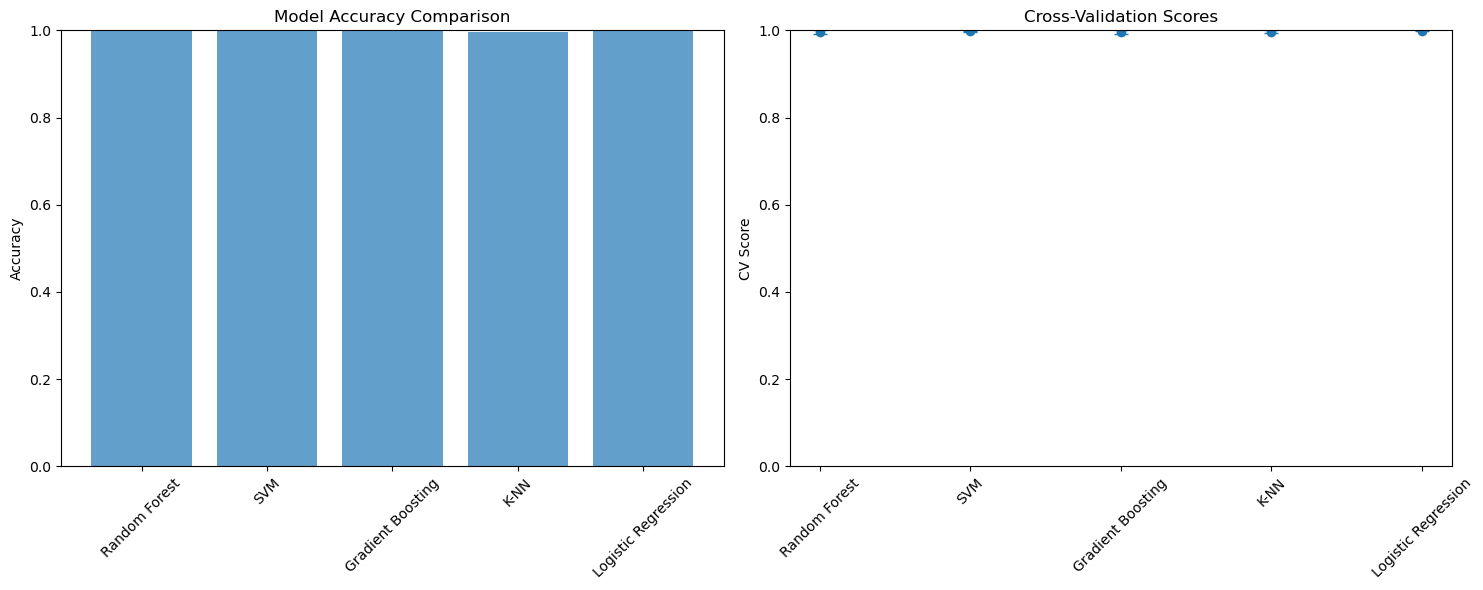

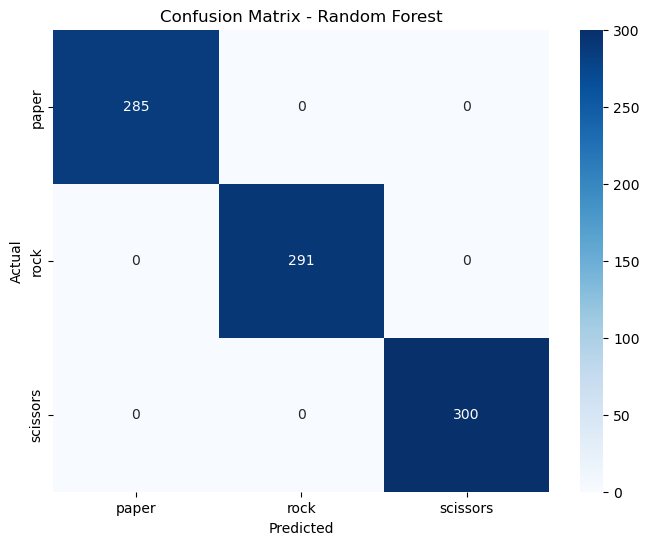


3. Deep Learning Classification

Training CNN with raw_rgb representation...


I0000 00:00:1751553149.109668  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
I0000 00:00:1751553149.113763  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1751553149.116883  240047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751553149.119598  240057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751553149.122043  240047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751553149.125045  240057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Training CNN model on cpu...
Epoch [10/20], Train Loss: 0.0457, Train Acc: 98.66%, Val Loss: 0.1660, Val Acc: 94.18%
Epoch [20/20], Train Loss: 0.0315, Train Acc: 99.37%, Val Loss: 0.0070, Val Acc: 99.77%


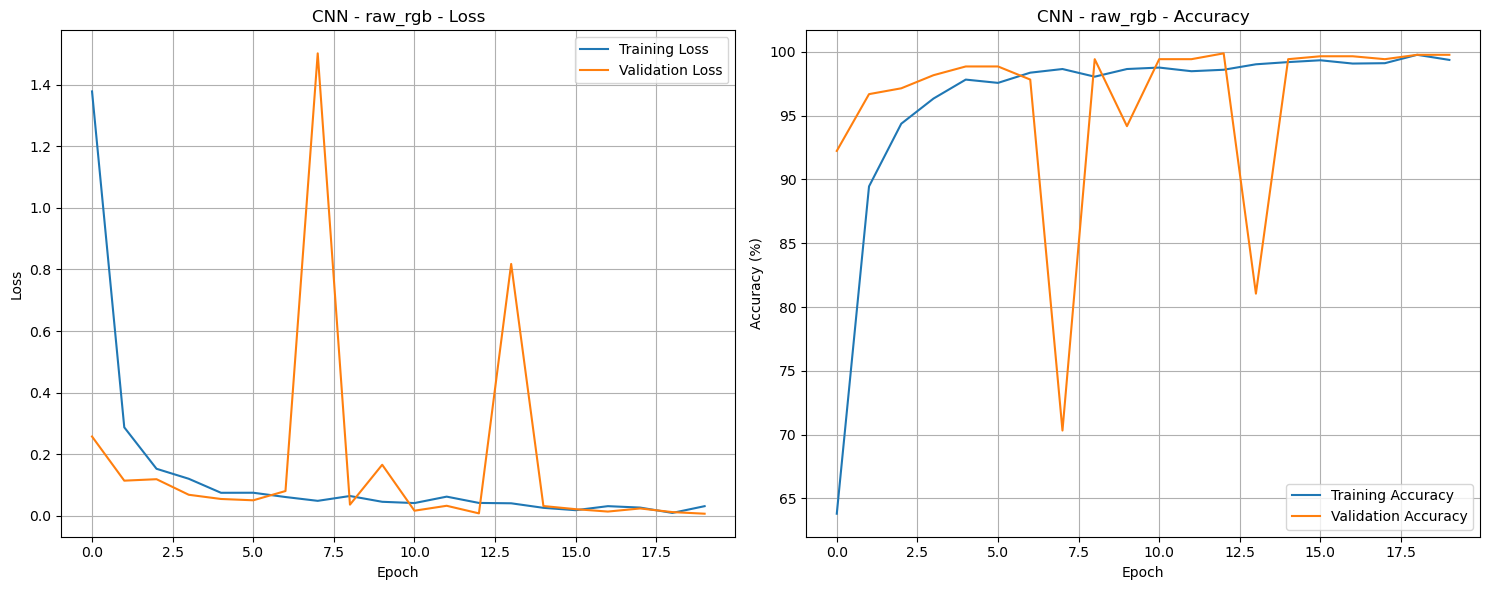


Training CNN with seg_mask representation...


I0000 00:00:1751564017.844606  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
I0000 00:00:1751564017.851486  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1751564017.857670  348869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564017.857770  348882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564017.862504  348882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564017.862629  348869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Training CNN model on cpu...
Error training CNN with seg_mask: mat1 and mat2 shapes cannot be multiplied (32x55296 and 50176x512)

Training CNN with edges representation...


I0000 00:00:1751564023.870504  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
I0000 00:00:1751564023.874509  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1751564023.875425  348942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564023.879424  348954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564023.879753  348950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564023.883309  348962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Training CNN model on cpu...
Error training CNN with edges: mat1 and mat2 shapes cannot be multiplied (32x55296 and 50176x512)

Training MLP with landmarks...
Training Landmark MLP on cpu...


I0000 00:00:1751564030.097417  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
I0000 00:00:1751564030.101196  209846 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1751564030.102383  348985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564030.106496  348996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564030.107001  348985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751564030.110883  349002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Error training MLP with landmarks: mat1 and mat2 must have the same dtype, but got Double and Float

4. Final Results Comparison
Best Traditional ML: 1.0000 accuracy
   Representations: ['landmarks', 'seg_mask']
   Best Model: Random Forest

Deep Learning Results:
   raw_rgb: 99.89% accuracy

Best Overall Approach: Traditional ML (100.00% accuracy)
=== Representation Effectiveness Analysis ===


RAW RGB:
  Best for: Deep learning with large datasets
  Traditional ML: Poor (too high dimensional)
  Deep Learning: Excellent
  Pros:
    + Contains all visual information
    + No preprocessing required
    + Works well with CNN architectures
    + Can capture subtle color variations
  Cons:
    - High dimensional (sensitive to lighting)
    - Requires large datasets
    - Computationally expensive
    - May overfit to background/lighting conditions

SEGMENTATION MASK:
  Best for: Traditional ML with geometric features
  Traditional ML: Good
  Deep Learning: Fair
  Pros:
    + Removes backgr

In [5]:
if __name__ == "__main__":
    # Example usage
    print("Starting Rock-Paper-Scissors Classification Experiment...")
    
    # Run comprehensive experiment
    results = run_comprehensive_rps_classification_experiment(DATASET_PATH)
    
    # Analyze representation effectiveness
    analysis = analyze_representation_effectiveness()
    
    # Save results
    if results:
        save_models(results['deep_learning'], "saved_models/")
    
    print("\nExperiment completed!")
    
    # Recommendations based on results
    print("\n=== RECOMMENDATIONS ===")
    print("1. For real-time applications: Use landmark-based MLP")
    print("2. For highest accuracy: Use ensemble of CNN + traditional ML")
    print("3. For limited data: Use traditional ML with landmark features")
    print("4. For mobile deployment: Use landmark MLP or simple CNN with edges")
    print("5. For production: Combine multiple representations in ensemble")
